# Running the file<br>
If you wish to use your own copy of the data, use the following command:<br>
<br>
``python lending-club-main.py [{-i |--input=}<loan-csv>] [-h | --help]``<br>
<br>
Here are some examples:<br>
<br>
``python lending-club-main.py --input=loan.csv``<br>
``python lending-club-main.py -i loan.csv``<br>
``python lending-club-main.py``<br>
``python lending-club-main.py --help``<br>
<br>
All of these arguments are optional. Providing no arguments makes the code read from the default location, i.e. ```./data```.<br>
<br>
# Instructions on regenerating this Jupyter Notebook<br>
The Jupyter notebook can be regenerated by installing P2J, like so:<br>
<br>
``pip install p2j``<br>
<br>
and running the following:<br>
<br>
``p2j -o code/lending-club-main.py -t notebook/lending-club-main.ipynb``

# Library Imports

In [1]:
import getopt
import logging
import sys
import warnings

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Constants<br>
A bunch of constants are set up so that strings don't clutter the source everywhere.

In [3]:
DEFAULT_DATASET_LOCATION = "../data"
DEFAULT_LOAN_CSV_FILENAME = "loan.csv"
ID = "id"
MEMBER_ID = "member_id"
DELINQUENT_2_YEARS = 'delinq_2yrs'
EARLIER_CREDIT_LINE = 'earliest_cr_line'
LAST_PAYMENT_AMOUNT = 'last_pymnt_amnt'
LAST_CREDIT_PULL_DATE = 'last_credit_pull_d'
APPLICATION_TYPE = 'application_type'
LAST_PAYMENT_DATE = 'last_pymnt_d'
COLLECTION_RECOVERY_FEE = 'collection_recovery_fee'
RECOVERIES = 'recoveries'
TOTAL_RECOVERED_LATE_FEE = 'total_rec_late_fee'
TOTAL_PAYMENT = 'total_pymnt'
TOTAL_PAYMENT_INVESTED = 'total_pymnt_inv'
TOTAL_RECOVERED_PRINCIPAL = 'total_rec_prncp'
OUT_PRINCIPAL_INVESTED = 'out_prncp_inv'
OUT_PRINCIPAL = 'out_prncp'
NUM_INQUIRIES_6_MONTHS = 'inq_last_6mths'
NUM_OPRN_CREDIT_LINES = 'open_acc'
NUM_DEROGATORY_PUBLIC_RECORDS = 'pub_rec'
TOTAL_CREDOT_REVOLVING_BALANCE = 'revol_bal'
REVOLVING_LINE_UTILISATION_RATE = 'revol_util'
CURRENT_NUM_CREDIT_LINES = 'total_acc'
INTEREST_RECEIVED_TILL_DATE = 'total_rec_int'
PAYMENT_PLAN = 'pymnt_plan'
INITIAL_LIST_STATUS = 'initial_list_status'
POLICY_CODE = 'policy_code'
URL = 'url'
EMPLOYMENT_TITLE = 'emp_title'
FUNDED_AMOUNT = 'funded_amnt'
FUNDED_AMOUNT_INVESTED = 'funded_amnt_inv'
INSTALLMENT = "installment"
LOAN_STATUS = 'loan_status'
INTEREST_RATE = 'int_rate'
EMPLOYMENT_LENGTH = 'emp_length'
ISSUE_DATE = 'issue_d'
ISSUE_MONTH = 'issue_month'
ISSUE_YEAR = 'issue_year'
MONTHS_SINCE_LAST_DELINQUENCY = "mths_since_last_delinq"
MONTHS_SINCE_LAST_RECORD = "mths_since_last_record"
NEXT_PAYMENT_DATE = "next_pymnt_d"
LOAN_AMOUNT = 'loan_amnt'
TERM = 'term'
INTEREST_RATE_CATEGORY = 'int_rate_cat'
GRADE = 'grade'
SUB_GRADE = 'sub_grade'
HOME_OWNERSHIP = 'home_ownership'
ANNUAL_INCOME = 'annual_inc'
VERIFICATION_STATUS = 'verification_status'
PURPOSE = 'purpose'
ADDRESS_STATE = 'addr_state'
DEBT_TO_INCOME_RATIO = 'dti'
TAX_LIENS = 'tax_liens'
DELINQ_AMNT = 'delinq_amnt'
CHARGEOFF_WITHIN_12_MTHS = 'chargeoff_within_12_mths'
ACC_NOW_DELINQ = 'acc_now_delinq'
COLLECTIONS_12_MTHS_EX_MED = 'collections_12_mths_ex_med'
FULLY_PAID = 'Fully Paid'
CURRENT = 'Current'
CHARGED_OFF = 'Charged Off'
BANKRUPTCIES = 'pub_rec_bankruptcies'
USELESS_COLUMNS = [TAX_LIENS, DELINQ_AMNT, CHARGEOFF_WITHIN_12_MTHS, ACC_NOW_DELINQ, COLLECTIONS_12_MTHS_EX_MED]
CONSTANT_VALUED_COLUMNS = [PAYMENT_PLAN, INITIAL_LIST_STATUS, POLICY_CODE, EMPLOYMENT_TITLE, URL]
CUSTOMER_BEHAVIOUR_COLUMNS = [DELINQUENT_2_YEARS, EARLIER_CREDIT_LINE, NUM_INQUIRIES_6_MONTHS, NUM_OPRN_CREDIT_LINES,
                              NUM_DEROGATORY_PUBLIC_RECORDS,
                              TOTAL_CREDOT_REVOLVING_BALANCE, REVOLVING_LINE_UTILISATION_RATE, CURRENT_NUM_CREDIT_LINES,
                              OUT_PRINCIPAL, OUT_PRINCIPAL_INVESTED, TOTAL_PAYMENT, TOTAL_PAYMENT_INVESTED,
                              TOTAL_RECOVERED_PRINCIPAL,
                              INTEREST_RECEIVED_TILL_DATE, TOTAL_RECOVERED_LATE_FEE, RECOVERIES,
                              COLLECTION_RECOVERY_FEE, LAST_PAYMENT_DATE,
                              LAST_PAYMENT_AMOUNT, LAST_CREDIT_PULL_DATE, APPLICATION_TYPE,
                              MONTHS_SINCE_LAST_DELINQUENCY, MONTHS_SINCE_LAST_RECORD, NEXT_PAYMENT_DATE]

# Cleaning Loan Data<br>
The cleanup consists of the following steps:<br>
- Removing `desc` column<br>
- Removing `member_id` column<br>
- Removing completely null columns<br>
- Removing customer behaviour columns which are not available for analysis for aspiring loan applicants<br>
- Removing columns which have constant values and do not contribute to analysis

In [4]:
def non_null_loans(raw_loans):
    ## Removing Desc column from dataset as it will be not helpful for us in this case study, whereas it can be helpful if we were solving NLP problem
    loans_wo_desc = raw_loans.drop('desc', axis=1)
    # Checking which column can be used as an identifier
    heading("Check which column can be used as an identifier")
    verify_id_member_id_columns_are_not_correlated(loans_wo_desc)
    loans_wo_desc_member_id = loans_wo_desc.drop(columns=[MEMBER_ID], axis=1)
    # Both this column can be used as an identifier, anyone of these can be dropped. Also none of this is helpful for our analysis. They are just identifier
    heading("Column Data Types")
    logging.debug(loans_wo_desc_member_id.dtypes)
    loans_wo_nulls = clean_null_columns(loans_wo_desc_member_id)
    heading("Loan Info after scrubbing completely empty columns")
    logging.debug(loans_wo_nulls.info())
    loans_wo_nulls = clean_customer_behaviour_columns(loans_wo_nulls)
    loans_wo_nulls = clean_constant_valued_columns(loans_wo_nulls)
    loans_wo_nulls = clean_useless_columns(loans_wo_nulls)
    return loans_wo_nulls

## Unindicative Columns Cleanup<br>
These columns are not useful because they have values either 0 or Nan value

In [5]:
def clean_useless_columns(loans):
    logging.debug(loans[COLLECTIONS_12_MTHS_EX_MED].value_counts())
    logging.debug(loans[ACC_NOW_DELINQ].value_counts())
    logging.debug(loans[CHARGEOFF_WITHIN_12_MTHS].value_counts())
    logging.debug(loans[DELINQ_AMNT].value_counts())
    logging.debug(loans[TAX_LIENS].value_counts())
    return loans.drop(columns=USELESS_COLUMNS, axis=1)

## Null Column Cleanup<br>
The loan dataset has several columns which are completely empty. These are useless for analysis.<br>
This function drops completely null columns.

In [6]:
def clean_null_columns(loans):
    heading("Null Entries Statistics")
    null_entry_statistics = loans.isnull().sum() / len(loans.index)
    null_columns = null_entry_statistics[null_entry_statistics == 1.0].index.to_numpy()
    heading("Completely Null Columns")
    logging.info(null_columns)
    return loans.drop(null_columns, axis=1)

Verifying that member_id's and id's are completely unique from each other

In [7]:
def verify_id_member_id_columns_are_not_correlated(loans):
    ids_as_number = pd.to_numeric(loans[ID])
    member_ids_as_number = pd.to_numeric(loans[MEMBER_ID])
    logging.info(f"Unique entries in id column : {ids_as_number.nunique()}")
    logging.info(f"Unique entries in member_id column : {member_ids_as_number.nunique()}")
    ids_not_in_member_ids = set(ids_as_number).difference(set(member_ids_as_number))
    member_ids_not_in_ids = set(member_ids_as_number).difference(set(ids_as_number))
    logging.info(f"id's not in member_id's = {len(ids_not_in_member_ids)}")
    logging.info(f"member_id's not in id's = {len(member_ids_not_in_ids)}")

## Dropping Customer Behaviour Columns<br>
Removing columns  which are customer behaviour variable. This values will not be available to us while customer is filling the loan form.<br>
Hence this will be not helpful for deciding whether customer will charged off or full pay

In [8]:
def clean_customer_behaviour_columns(loans_wo_nulls):
    return loans_wo_nulls.drop(columns=CUSTOMER_BEHAVIOUR_COLUMNS, axis=1)

## Constant-Valued Columns<br>
There are a few columns which have constant values. Such as pymnt_plan,initial_list_status,policy_code. We can drop these. Along with this, we can also drop<br>
emp_title and URL column because they too don't contain values which can help do decide loan_status

In [9]:
def clean_constant_valued_columns(loans_wo_nulls):
    logging.info(f"Unique Values in column pymnt_plan: {loans_wo_nulls[PAYMENT_PLAN].nunique()}")
    logging.info(f"Unique Values in column initial_list_status: {loans_wo_nulls[INITIAL_LIST_STATUS].nunique()}")
    logging.info(f"Unique Values in column policy_code: {loans_wo_nulls[POLICY_CODE].nunique()}")
    return loans_wo_nulls.drop(columns=CONSTANT_VALUED_COLUMNS, axis=1)

# Checking Correlation between columns<br>
We check the correlation between pairs of columns, this gives us a statistic (the default being the Pearson correlation coefficient).<br>
The correlation coefficient gives a measure of how one factor varies with the other.

In [10]:
def multicollinear_free_loads(loans):
    heading("Check for Highly Correlated variables")
    correlations = loans.corr()
    indexes = correlations.index.to_numpy()
    heading("Correlation Coefficients")
    logging.info(correlations.to_string())
    heading("Highly Correlated Columns")
    for row in indexes:
        for col in indexes:
            if (row == col):
                continue
            if (correlations[row][col] >= 0.85):
                logging.info(f"[{row},{col}] = {correlations[row][col]}")

    # loan_amnt, funded_amnt and funded_amnt_inv have high correlation. High correlation means they all contains the same information. We can drop 2 out of 3.
    # we will keep loan_amnt and rest 2 can be dropped.
    # installment is also highly correlated
    return loans.drop(columns=[FUNDED_AMOUNT, FUNDED_AMOUNT_INVESTED], axis=1)

# Remove loans which are of status CURRENT<br>
Loans with `CURRENT` status are current customers involved in paying off their loans.<br>
These loans do not provide us with any training information from which we can infer any conclusions.

In [11]:
def loans_without_current_loans(loans):
    heading("Loan Statuses: There should only be 3 categories")
    logging.info(loans[LOAN_STATUS].value_counts())
    print("Shape of the data before dropping rows", loans.shape)
    loans_wo_current = loans[loans[LOAN_STATUS] != CURRENT]
    print("Shape of the data after dropping rows", loans_wo_current.shape)
    return loans_wo_current

# Recheck Null Values after Cleanup<br>
We still have null values in the data. We can fill those values. But EDA doesn't require to fill. Handling missing value is part of modelling.

In [12]:
def recheck_null_values(loans_with_corrected_data_types):
    heading("Null value checks after Cleanup")
    logging.info(loans_with_corrected_data_types.isnull().sum())

# Correction of Data Types<br>
Some columns needed for numerical EDA do not show up as numbers, or properly-formatted dates.<br>
Examples are: for `interest rate`, `employment length` and `issue date`. We fix these factors here.

In [13]:
def corrected_data_types(loans):
    loans = loans.copy()
    loans[INTEREST_RATE] = loans[INTEREST_RATE].apply(lambda x: float(str(x).replace('%', '')))
    loans[EMPLOYMENT_LENGTH] = loans[EMPLOYMENT_LENGTH].apply(
        lambda x: float(str(x).replace('years', '').replace('year', '').replace('+', '').replace('< 1', '0.5')))
    loans[ISSUE_DATE] = pd.to_datetime(loans[ISSUE_DATE], format='%b-%y')
    loans[ISSUE_MONTH] = pd.DatetimeIndex(loans[ISSUE_DATE]).month
    loans[ISSUE_YEAR] = pd.DatetimeIndex(loans[ISSUE_DATE]).year
    return loans

# Univariate (Unsegmented) Analysis

In [14]:
def analyse_univariate_unsegmented(loans):
    plot_loan_amount_distribution_univariate(loans)
    plot_loan_requests_by_month_univariate(loans)
    plot_loan_requests_by_year_univariate(loans)
    plot_term_counts_univariate(loans)
    plot_interest_rate_distribution_univariate(loans)
    plot_loan_grade_distribution_univariate(loans)
    plot_loan_sub_grade_distribution_univariate(loans)
    plot_employment_length_distribution_univariate(loans)
    plot_home_ownership_distributions_univariate(loans)
    plot_annual_income_distribution_univariate(loans)
    plot_verification_status_distribution_univariate(loans)
    plot_loan_purpose_distribution_univariate(loans)
    plot_loan_purpose_distribution_for_defaulters(loans)
    plot_address_state_distribution_univariate(loans)
    plot_dti_distribution_univariate(loans)
    plot_dti_distribution_univariate_for_defaulters(loans)
    loans[DEBT_TO_INCOME_RATIO].describe()
    ### Higher the DTI, higher % of monthly income is paid towards EMI
    loans['pub_rec_bankruptcies'].value_counts().plot.barh()
    plt.title("Filed Public Bankruptcies")
    plt.xlabel("Count")
    plt.ylabel("Number of Filing")
    plt.show()
    #### Very Few Appliant have filed for bankruptcies

# Segmented Univariate Analysis

In [15]:
def analyse_univariate_segmented(loans):
    plot_pi_overall_charged_off_vs_paid(loans)
    plot_loan_amount_across_time_by_loan_status(loans)
    for i in loans.select_dtypes(include=['int', 'float']).columns:
        sns.boxplot(data=loans, x=LOAN_STATUS, y=i)
        plt.title("Loan Status vs " + i)
        plt.show()
    plot_requested_loan_amount_by_loan_status(loans)
    plot_users_term_by_loan_status(loans)
    loans[INTEREST_RATE_CATEGORY] = pd.cut(loans[INTEREST_RATE], 4, labels=["low", "med", "high", "vhigh"])
    logging.info(pd.cut(loans[INTEREST_RATE], 4, ).value_counts())
    plot_users_loan_category_by_loan_status(loans)
    plot_installment_by_loan_status(loans)
    plot_loan_amount_by_loan_status(loans)
    plot_loan_amount_by_loan_status(loans, bin_width=5000)
    loans.groupby(by=[GRADE])[LOAN_STATUS].value_counts().unstack().apply(lambda x: x / sum(x), axis=1).plot(kind='bar',
                                                                                                             stacked=True)
    plot_sub_grade_by_loan_status(loans)
    plot_employment_length_by_loan_status(loans)
    plot_home_ownership_by_loan_status(loans)
    plot_annual_income_by_loan_status(loans)
    logging.info(loans[ANNUAL_INCOME].describe().apply(lambda x: '%.5f' % x))
    plot_restricted_annual_income_by_loan_status(loans)
    plot_verification_status_by_loan_status(loans)
    plot_users_loan_purpose_by_loan_status(loans)

# Bivariate Analysis

In [16]:
def analyse_bivariate(loans):
    logging.info(loans.groupby(by=LOAN_STATUS)[LOAN_AMOUNT].describe())
    #### Mean is higher in both the cases of loan_status with respect to median, this show right skew data
    #### The user who is defaulter ask for higher loan amount compared to Non-Defaulter
    pair_plot_across_all_attributes(loans)
    plot_verification_status_for_independent_loan_statuses(loans)
    plot_grade_subgrade_heatmap_by_loan_status(loans)
    plot_yearly_monthly_by_loan_status(loans)
    plot_loan_amount_by_loan_status_for_different_terms(loans)
    plot_interest_rate_loan_amount_for_loan_statuses(loans)
    plot_installment_loan_amount_for_loan_statuses(loans)
    plot_installment_bankruptcies_for_loan_statuses(loans)
    plot_loan_amount_employment_length_for_loan_statuses(loans)
    plot_loan_amount_grade_for_loan_statuses_for_terms(loans)
    plot_verification_status_grade_for_loan_statuses(loans)
    print_stats_annual_income_for_loan_statuses(loans)
    print_stats_loan_amount_for_loan_statuses(loans)
    plot_home_ownership_loan_amount_for_loan_statuses(loans)

# Analysis Entry Point

In [17]:
def analyse(loans):
    analyse_univariate_unsegmented(loans)
    analyse_univariate_segmented(loans)
    analyse_bivariate(loans)

# EDA Plot Functions<br>
This section contains all the plot functions used in Univariate (Segmented and Unsegmented) and Bivariate EDA

In [18]:
def plot_loan_amount_by_loan_status_for_different_terms(loans):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=loans[loans[TERM] == ' 36 months'], x=LOAN_AMOUNT, hue=LOAN_STATUS, multiple='stack')
    plt.title("36 Month Term Loan")
    plt.ylabel("Number of applicant")
    plt.subplot(1, 2, 2)
    sns.histplot(data=loans[loans['term'] != ' 36 months'], x=LOAN_AMOUNT, hue=LOAN_STATUS, multiple='stack')
    plt.title("60 Month Term Loan")
    plt.show()

In [19]:
def plot_interest_rate_loan_amount_for_loan_statuses(loans):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=loans[loans[LOAN_STATUS] == 0], x=LOAN_AMOUNT, y=INTEREST_RATE)
    plt.title("Non-Defaulter")
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=loans[loans[LOAN_STATUS] == 1], x=LOAN_AMOUNT, y=INTEREST_RATE)
    plt.title("Defaulter")
    plt.show()

In [20]:
def plot_installment_loan_amount_for_loan_statuses(loans):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=loans, x=LOAN_AMOUNT, y=INSTALLMENT, hue=LOAN_STATUS)
    plt.show()
    #### As loan amount increases, installement per month increases

In [21]:
def plot_installment_bankruptcies_for_loan_statuses(loans):
    sns.barplot(data=loans, x=BANKRUPTCIES, y=INSTALLMENT, hue=LOAN_STATUS, estimator=lambda x: np.mean(x))
    plt.show()
    ### As Installement is high, the installement is also high for defaulters

In [22]:
def plot_loan_amount_employment_length_for_loan_statuses(loans):
    ## Added new at @4.38pm
    sns.barplot(data=loans, y=LOAN_AMOUNT, x=EMPLOYMENT_LENGTH, hue=LOAN_STATUS)
    plt.title("Employement Length vs Avg. Loan Amount")
    plt.show()
    #### Defaulters ask for higher loan amount

In [23]:
def plot_verification_status_grade_for_loan_statuses(loans):
    sns.heatmap(
        data=loans.groupby(by=[VERIFICATION_STATUS, GRADE])[LOAN_STATUS].sum().unstack().apply(lambda x: x / sum(x),
                                                                                               axis=0),
        cmap='Reds')
    plt.show()
    ### Verified have the lowest grade have highest defaulters.
    ### Applicant whose income source is not verified and getting a grade from high to lowest have defaulter

In [24]:
def print_stats_annual_income_for_loan_statuses(loans):
    logging.info(loans.groupby(by='loan_status')['annual_inc'].describe())
    #### Defaulters Applicant have lower annual Income
    ### But they are asking for higher amount as loan

In [25]:
def print_stats_loan_amount_for_loan_statuses(loans):
    logging.info(loans.groupby(by=LOAN_STATUS)[ANNUAL_INCOME].describe())
    #### Defaulters Applicant have lower annual Income
    ### But they are asking for higher amount as loan

In [26]:
def plot_home_ownership_loan_amount_for_loan_statuses(loans):
    for i in list(loans[HOME_OWNERSHIP].unique()):
        sns.barplot(data=loans[loans[HOME_OWNERSHIP] == i], x=TERM, y=LOAN_AMOUNT, hue=LOAN_STATUS)
        plt.title(str(i) + " Home OwnerShip and Term")
        plt.show()

In [27]:
def plot_loan_amount_grade_for_loan_statuses_for_terms(loans):
    for i in list(loans[EMPLOYMENT_LENGTH].unique())[:-1]:
        sns.barplot(data=loans[loans[EMPLOYMENT_LENGTH] == i], y=LOAN_AMOUNT, x=GRADE, hue=LOAN_STATUS)
        plt.title(str(i) + " year Employee's Grade vs Avg. Loan Amount")
        plt.show()

In [28]:
def plot_dti_distribution_univariate(loans):
    sns.displot(data=loans, x=DEBT_TO_INCOME_RATIO)
    plt.title("Distribution of Debt to Income Ratio")
    plt.show()
    ### Data seems to be normally distributed, Median and mean is almost eqauls

In [29]:
def plot_dti_distribution_univariate_for_defaulters(loans):
    defaulters = loans[loans[LOAN_STATUS] == CHARGED_OFF]
    sns.displot(data=defaulters, x=DEBT_TO_INCOME_RATIO)
    plt.title("Distribution of Debt to Income Ratio for Defaulters Only")
    plt.show()

In [30]:
def plot_address_state_distribution_univariate(loans):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=loans[ADDRESS_STATE].value_counts().reset_index(), x='index', y='addr_state', )
    plt.title("States of the Applicant")
    plt.xlabel("States")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()
    ### Highest Applicant are from CA,NY and lowest from NE,ME

In [31]:
def plot_loan_purpose_distribution_univariate(loans):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=loans[PURPOSE].value_counts().reset_index(), x='index', y="purpose", estimator=lambda x: np.sum(x))
    plt.title("Purpose of the Loan")
    plt.xticks(rotation=90)
    plt.xlabel("Purpose")
    plt.ylabel("Count")
    plt.show()
    ### Applicant is taking a loan for Debt_Consolidation, Credit Card

In [32]:
def plot_loan_purpose_distribution_for_defaulters(loans):
    defaulters = loans[loans[LOAN_STATUS] == CHARGED_OFF]
    plt.figure(figsize=(10, 5))
    sns.barplot(data=defaulters[PURPOSE].value_counts().reset_index(), x='index', y="purpose",
                estimator=lambda x: np.sum(x))
    plt.title("Purpose of the Loan for Defaulters")
    plt.xticks(rotation=90)
    plt.xlabel("Purpose")
    plt.ylabel("Count")
    plt.show()
    ### Applicant is taking a loan for Debt_Consolidation, Credit Card

In [33]:
def plot_verification_status_distribution_univariate(loans):
    loans[VERIFICATION_STATUS].value_counts(1).plot.pie(autopct='%1.1f%%')
    plt.title("Income Verification of the Loan Applicant")
    plt.show()
    #### 43% of applicant's income source wasn't verified

In [34]:
def plot_annual_income_distribution_univariate(loans):
    pd.options.display.float_format = '{:.2f}'.format
    sns.histplot(data=loans, x=ANNUAL_INCOME, kde=True)
    plt.title("Annual Income of the Applicant")
    plt.show()
    #### Data is Right Skew.
    logging.info(loans[ANNUAL_INCOME].describe())
    ## Average Income is greater than Median Income. Income ranges from 4,000 to 6,00,000

In [35]:
def plot_home_ownership_distributions_univariate(loans):
    loans['home_ownership'].value_counts().plot.barh()
    plt.title("Home Ownership")
    plt.show()
    #### Applicants is living either on Rent or on Mortgage propoerty

In [36]:
def plot_employment_length_distribution_univariate(loans):
    loans[EMPLOYMENT_LENGTH].value_counts().plot.bar()
    plt.title("Employment Length")
    plt.xlabel("Years of experience")
    plt.ylabel("Count of Applicant")
    plt.show()
    ### Most of the Applicant have 10Years of experience

In [37]:
def plot_loan_sub_grade_distribution_univariate(loans):
    loans[SUB_GRADE].value_counts().plot.bar(title='Sub Grade Frequency');
    plt.xlabel("Sub Grade")
    plt.ylabel("Count")
    plt.show()
    #### Many Users have been assigned with A4 grade, few people have been assigned with G5 grade
    ### B3 garde is the highest in B grade

In [38]:
def plot_loan_grade_distribution_univariate(loans):
    loans[GRADE].value_counts().plot.bar(title='Grade Frequency');
    plt.xlabel("Grade")
    plt.ylabel("Count")
    plt.show()
    #### More Users have been assigned B grade, few people have been assigned with G grade

In [39]:
def plot_interest_rate_distribution_univariate(loans):
    sns.displot(data=loans, x=INTEREST_RATE, kind='hist', color='blue')
    plt.title("Distribution of Interest Rate")
    plt.show()

In [40]:
def plot_term_counts_univariate(loans):
    loans[TERM].value_counts(1).plot.pie();
    ### Most of the users have taken a loan for shorter period i.e. 36 month compared to 60 months

In [41]:
def plot_loan_requests_by_year_univariate(loans):
    loans[ISSUE_YEAR].value_counts().plot.line();
    plt.title("Year & Loan Request")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()
    #### We are seeing number of loan request increasing year over year. Exponentiat growth can be seen
    ### In 2011 we see highest number of loan request

In [42]:
def plot_loan_requests_by_month_univariate(loans):
    loans[ISSUE_MONTH].value_counts().plot.line();
    plt.title("Month & Loan Request")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.show()
    #### We are seeing number of loan request increasing as month passes.
    ### In Dec we see highest number of loan request, lowest in Feb

In [43]:
def plot_loan_amount_distribution_univariate(loans):
    # Distribution of loan amount
    plt.figure(figsize=(10, 5))
    sns.histplot(data=loans, x=LOAN_AMOUNT, kde=True)
    plt.title("Distribution of Loan Amount")
    plt.show()
    #### More numbers of loan were taken for amount 5000-1000. We see spike at multiples of 5000 i.e. 5000,10000,15000 etc

In [44]:
def plot_sub_grade_by_loan_status(loans):
    plt.figure(figsize=(10, 6))
    loans.groupby(by=[SUB_GRADE])[LOAN_STATUS].value_counts().unstack().apply(lambda x: x / sum(x), axis=1).plot(
        kind='bar', stacked=True);

In [45]:
def plot_verification_status_by_loan_status(loans):
    loans.groupby(by=[VERIFICATION_STATUS, LOAN_STATUS])[LOAN_STATUS].count().unstack().fillna(0).plot.bar()
    plt.show()

In [46]:
def plot_restricted_annual_income_by_loan_status(loans):
    sns.boxplot(data=loans[(loans[ANNUAL_INCOME] > 10000) & (loans[ANNUAL_INCOME] < 100000)], y=ANNUAL_INCOME,
                x=LOAN_STATUS)

In [47]:
def plot_annual_income_by_loan_status(loans):
    sns.boxplot(data=loans, y=ANNUAL_INCOME, x=LOAN_STATUS)

In [48]:
def plot_home_ownership_by_loan_status(loans):
    loans.groupby(by=[HOME_OWNERSHIP, LOAN_STATUS])[LOAN_STATUS].count().unstack().fillna(0).plot.bar()
    plt.title("Home Ownership")
    plt.show()

In [49]:
def plot_employment_length_by_loan_status(loans):
    sns.histplot(data=loans, x=EMPLOYMENT_LENGTH, hue=LOAN_STATUS, multiple='stack');

In [50]:
def plot_installment_by_loan_status(loans):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=loans[loans[LOAN_STATUS] == FULLY_PAID], x=INSTALLMENT)
    plt.subplot(1, 2, 2)
    sns.histplot(data=loans[loans[LOAN_STATUS] != FULLY_PAID], x=INSTALLMENT, color='r')
    plt.show()

In [51]:
def plot_loan_amount_by_loan_status(loans, bin_width=1000):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=loans[loans[LOAN_STATUS] == FULLY_PAID], x=LOAN_AMOUNT, binwidth=bin_width)
    plt.subplot(1, 2, 2)
    sns.histplot(data=loans[loans[LOAN_STATUS] != FULLY_PAID], x=LOAN_AMOUNT, color='r', binwidth=bin_width)
    plt.show()

In [52]:
def plot_users_loan_category_by_loan_status(loans):
    loans.groupby(by=[INTEREST_RATE_CATEGORY, LOAN_STATUS])[LOAN_STATUS].count().unstack().apply(
        lambda x: x / sum(x),
        axis=1).plot(
        kind='bar', stacked=True)
    plt.show()

In [53]:
def plot_users_loan_purpose_by_loan_status(loans):
    loans.groupby(by=[PURPOSE, LOAN_STATUS])[LOAN_STATUS].count().unstack().apply(
        lambda x: x / sum(x),
        axis=1).plot(
        kind='bar', stacked=True)
    plt.show()

In [54]:
def plot_requested_loan_amount_by_loan_status(loans):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=loans, x=LOAN_AMOUNT, hue=LOAN_STATUS, binwidth=1000, multiple="stack")
    plt.title("Loan Amount Requested Distribution")
    plt.xlabel("Loan Amount Requested")
    plt.show()

In [55]:
def plot_users_term_by_loan_status(loans):
    plt.figure(figsize=(10, 8))
    loans.groupby(by=[TERM, LOAN_STATUS])[LOAN_STATUS].count().unstack().apply(lambda x: x / sum(x), axis=1).plot(
        kind='bar', stacked=True)
    plt.title("Distribution of users for loan term")

In [56]:
def plot_loan_amount_across_time_by_loan_status(loans):
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=loans, x=ISSUE_DATE, y=LOAN_AMOUNT, hue=LOAN_STATUS)
    plt.title("Loan Given across the date")
    plt.xticks(rotation=90)
    plt.show()

In [57]:
def plot_pi_overall_charged_off_vs_paid(loans):
    plt.pie(loans[LOAN_STATUS].value_counts(1), labels=loans[LOAN_STATUS].value_counts(1).index.to_list(),
            explode=[0.1, 0.1], shadow=True, autopct='%.2f%%')
    plt.title("% of Users")
    plt.show()

In [58]:
def plot_verification_status_for_independent_loan_statuses(loans):
    loan_status_by_verification_status = round(
        loans.groupby(by=[LOAN_STATUS, VERIFICATION_STATUS])[LOAN_STATUS].count().unstack().apply(lambda x: x / sum(x),
                                                                                                  axis=1) * 100, 2)
    heading("Loan Status vs. Verification Status Statistics")
    logging.info(loan_status_by_verification_status)
    round(
        loans.groupby(by=[LOAN_STATUS, VERIFICATION_STATUS])[LOAN_STATUS].count().unstack().apply(lambda x: x / sum(x),
                                                                                                  axis=1) * 100,
        2).plot.barh(figsize=(10, 10))
    ##### Verified user are getting more default
    plt.show()

In [59]:
def plot_grade_subgrade_heatmap_by_loan_status(loans):
    loans[LOAN_STATUS] = np.where(loans[LOAN_STATUS] == CHARGED_OFF, 1, 0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(data=loans.groupby(by=[GRADE, SUB_GRADE])[LOAN_STATUS].mean().unstack().fillna(-1), cmap='Reds')
    plt.show()
    #### Users who get F5 subgrade defaults more followed by G3

In [60]:
def plot_yearly_monthly_by_loan_status(loans):
    loans.groupby(by=[ISSUE_YEAR, ISSUE_MONTH])[LOAN_STATUS].sum().plot.bar(figsize=(20, 5),
                                                                            title="Number of Defaulters YoY")
    plt.xlabel("Issue Year & Month")
    plt.ylabel("Defaulter Count")
    plt.show()
    ### Defaulters are increasing every year, though we have seen financial crisis in 2008, but they didn't defaulted much

In [61]:
def pair_plot_across_all_attributes(loans):
    sns.pairplot(data=loans)
    plt.show()

# Entry Point for CRISPR<br>
 This function is the entry point for the entire CRISPR process. This is called by `main()`

In [62]:
def study(raw_loans):
    logging.debug(raw_loans.head().to_string())
    # Number of Rows and Columns in the data set
    logging.debug(raw_loans.shape)
    logging.debug(raw_loans.columns)
    loans_wo_unneeded_columns = non_null_loans(raw_loans)
    loans_wo_correlated_factors = multicollinear_free_loads(loans_wo_unneeded_columns)
    loans_wo_current = loans_without_current_loans(loans_wo_correlated_factors)
    loans_with_corrected_data_types = corrected_data_types(loans_wo_current)
    recheck_null_values(loans_with_corrected_data_types)
    loans_with_corrected_data_types.set_index(keys=ID, inplace=True)
    analyse(loans_with_corrected_data_types)

# Utility Functions<br>
This function reads command line arguments, one of which can be the input loan data set

In [63]:
def parse_commandline_options(args):
    print(f"args are: {args}")
    loan_csv = f"{DEFAULT_DATASET_LOCATION}/{DEFAULT_LOAN_CSV_FILENAME}"
    try:
        options, arguments = getopt.getopt(args, "i:hf:", ["input=", "help"])
        for option, argument in options:
            if option in ("-h", "--help"):
                print_help_text()
            elif option in ("-i", "--input"):
                loan_csv = argument
            else:
                print(f"{option} was not recognised as a valid option")
                print_help_text()
                print("Allowing to continue since Jupyter notebook passes in other command-line options")
        return loan_csv
    except getopt.GetoptError as e:
        sys.stderr.write("%s: %s\n" % (args[0], e.msg))
        print_help_text()
        exit(2)

This function prints out the help text if either explicitly requested or in case of wrong input

In [64]:
def print_help_text():
    print("USAGE: python lending-club-main.py [{-i |--input=}<loan-csv>]")

This function overrides Jupyter's default logger so that we can output things based on our formatting preferences

In [65]:
def setup_logging():
    warnings.filterwarnings("ignore")
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logger = logging.getLogger()
    formatter = logging.Formatter('%(message)s')
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(ch)

This function reads the loan data set

In [66]:
def read_csv(loan_csv):
    return pd.read_csv(loan_csv, low_memory=False)

This utility function pretty prints a heading for output

In [67]:
def heading(heading_text):
    logging.info("-" * 100)
    logging.info(heading_text)
    logging.info("-" * 100)

# Main Entry Point: main()<br>
This function is the entry point of the script

In [68]:
def main():
    setup_logging()
    study(read_csv(parse_commandline_options(sys.argv[1:])))

args are: ['-f', '/Users/asgupta/Library/Jupyter/runtime/kernel-74c769dd-d29e-4a0d-9cf6-688eac20ebef.json']
-f was not recognised as a valid option
USAGE: python lending-club-main.py [{-i |--input=}<loan-csv>]
Allowing to continue since Jupyter notebook passes in other command-line options


        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status issue_d  loan_status pymnt_plan                                                               url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            desc         purpose                 title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  m

(39717, 111)
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)
----------------------------------------------------------------------------------------------------
Check which column can be used as an identifier
----------------------------------------------------------------------------------------------------
Unique entries in id column : 39717
Unique entries in member_id column : 39717
id's not in member_id's = 38073
member_id's not in id's = 38073
----------------------------------------------------------------------------------------------------
Column Data Types
---------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   loan_amnt                   39717 non-null  int64  
 2   funded_amnt                 39717 non-null  int64  
 3   funded_amnt_inv             39717 non-null  float64
 4   term                        39717 non-null  object 
 5   int_rate                    39717 non-null  object 
 6   installment                 39717 non-null  float64
 7   grade                       39717 non-null  object 
 8   sub_grade                   39717 non-null  object 
 9   emp_title                   37258 non-null  object 
 10  emp_length                  38642 non-null  object 
 11  home_ownership              39717 non-null  object 
 12  annual_inc                  39717 non-null  float64
 13  verification_status         397

----------------------------------------------------------------------------------------------------
Null value checks after Cleanup
----------------------------------------------------------------------------------------------------
id                         0
loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length              1033
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
title                     11
zip_code                   0
addr_state                 0
dti                        0
pub_rec_bankruptcies     697
issue_month                0
issue_year                 0
dtype: int64
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSa

findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Noto Sans Manichaean' (NotoSansManichaean-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal 900 normal>) = 10.525
findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.145
findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 7.698636363636363
findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold Italic.ttf) italic normal 700 condensed>) = 11.535
findfont: score(<Font '

findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'PT Mono' (PTMono.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Noto Sans Hanunoo' (NotoSansHanunoo-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Linear A' (NotoSansLinearA-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kann

findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal 295 normal>) = 10.14975
findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Noto Sans Mahajani' (NotoSansMahajani-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Academy Engraved LET' (Academy Engraved LET Fonts.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Batak' (NotoSan

findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33

findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal 900 normal>) = 10.525
findfont: score(<Font 'Kannada Sangam MN' (Kannada Sa

findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Meetei Mayek' (NotoSansMeeteiMayek-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF NS Mono' (SFNSMonoItalic.ttf) italic normal 295 normal>) = 11.14975
findfont: score(<Font 'Noto Sans Duployan' (NotoSansDuployan-Regular.ttf) normal 

findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 500 normal>) = 10.145
findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 4.971363636363637
findfont: score(<Font '.SF Compact' (SFCompactItalic.ttf) italic normal 1000 normal>) = 11.62
findfont: score(<Font 'Meslo LG M for Powerline' (Meslo LG M Regular for Powerline.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Party LET' (PartyLET-plain.ttf

findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.145
findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Avestan' (NotoSansAvestan-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 250 normal>) = 10.1925
findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIt

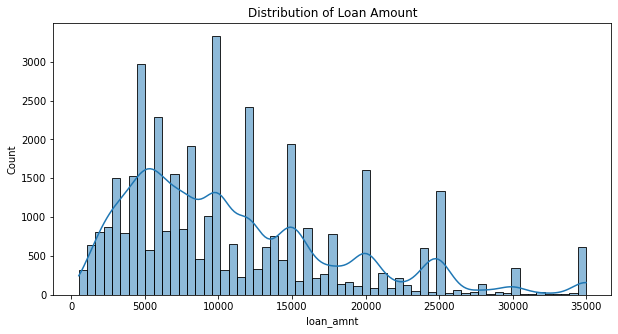

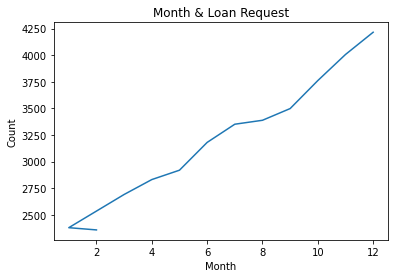

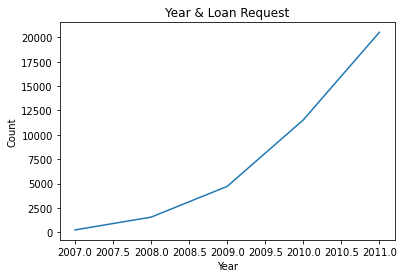

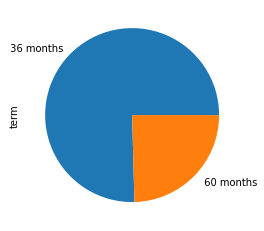

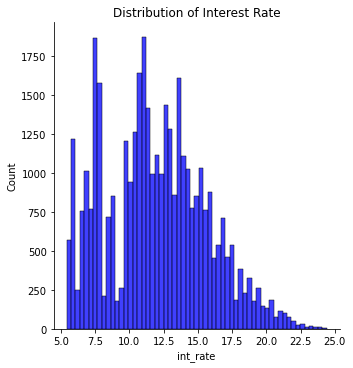

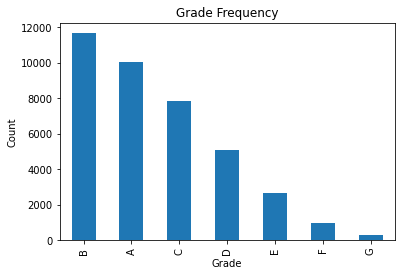

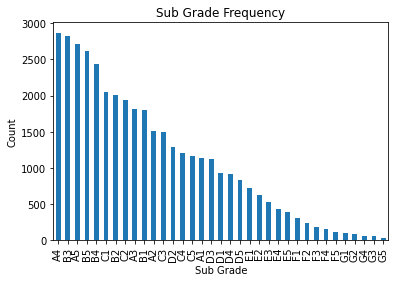

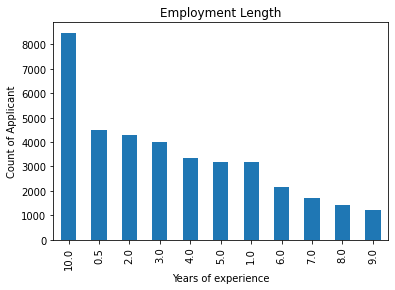

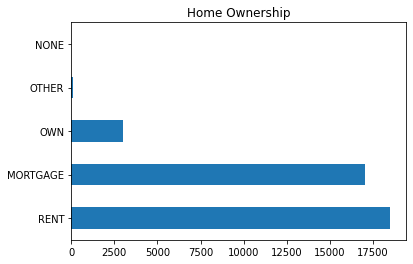

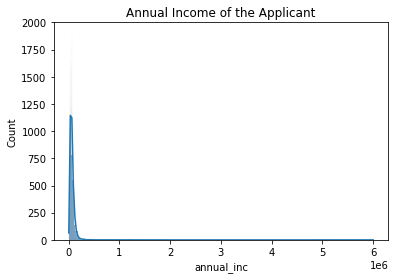

count     38577.00
mean      68777.97
std       64218.68
min        4000.00
25%       40000.00
50%       58868.00
75%       82000.00
max     6000000.00
Name: annual_inc, dtype: float64


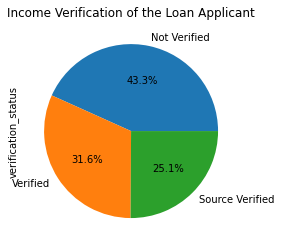

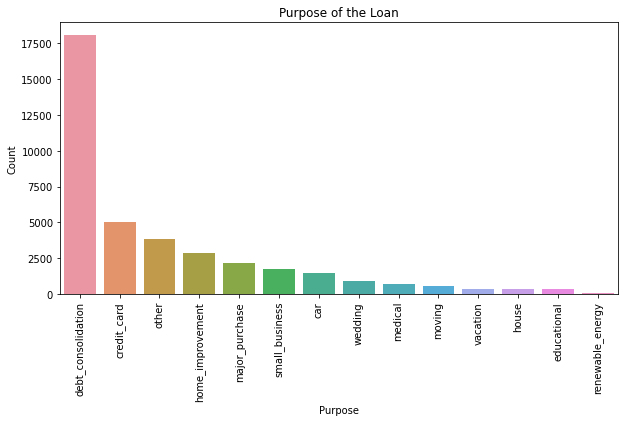

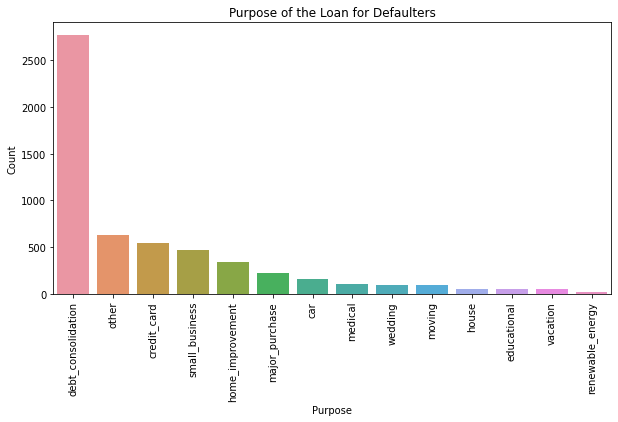

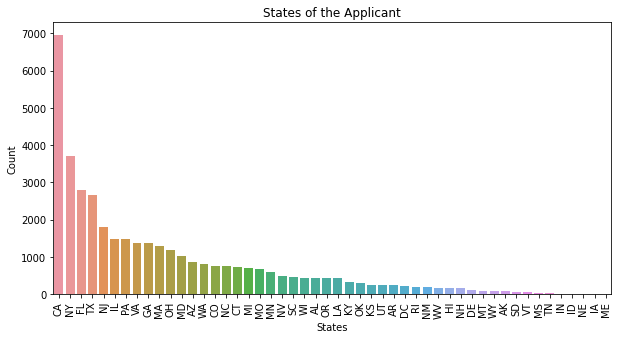

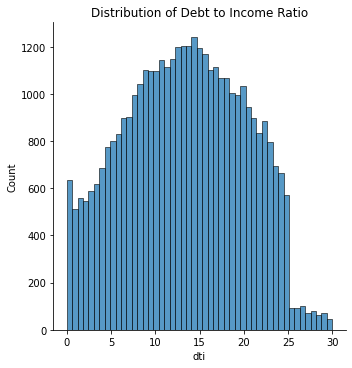

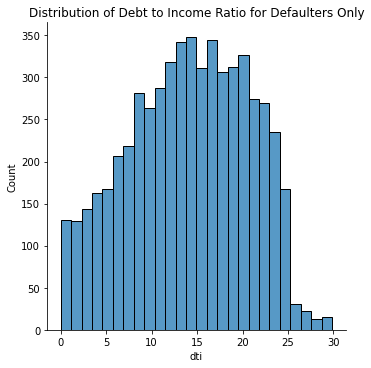

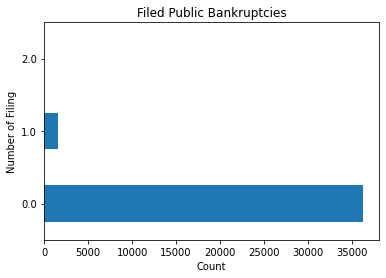

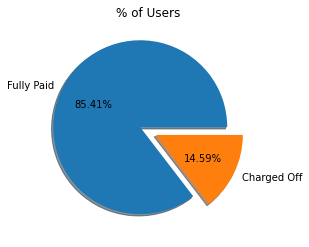

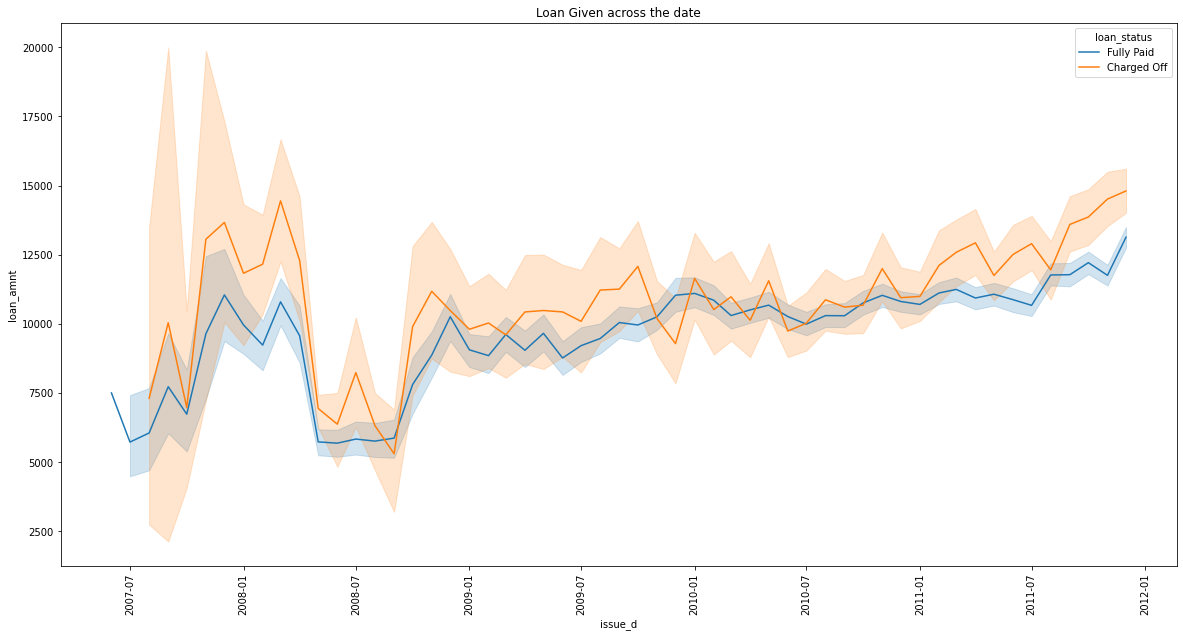

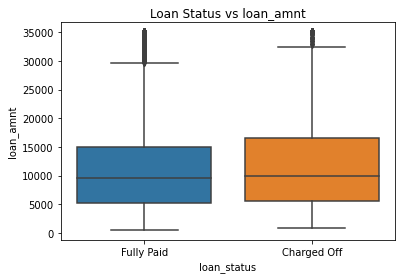

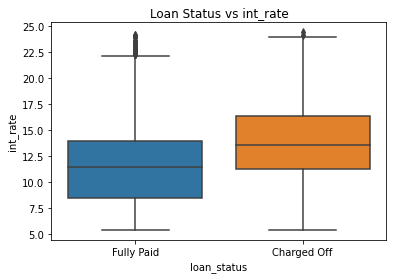

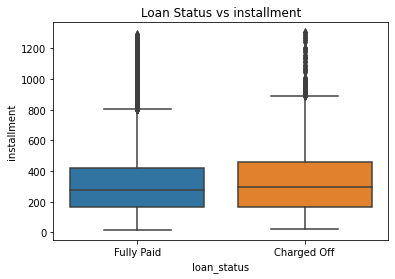

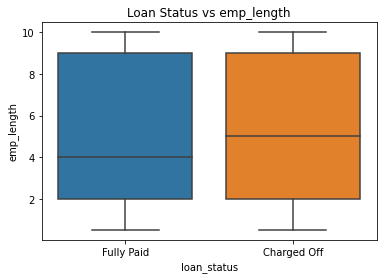

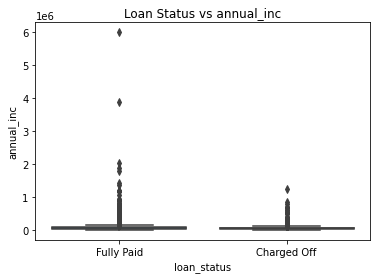

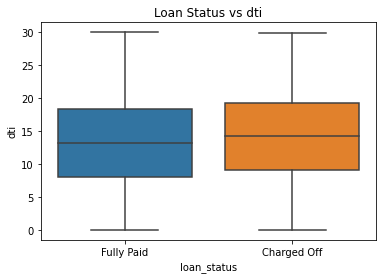

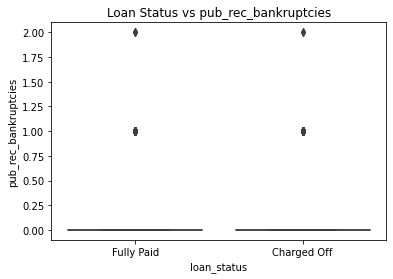

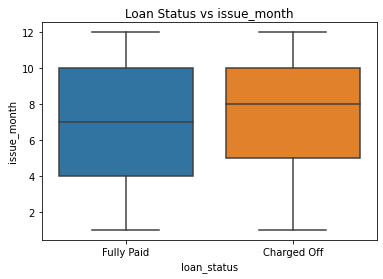

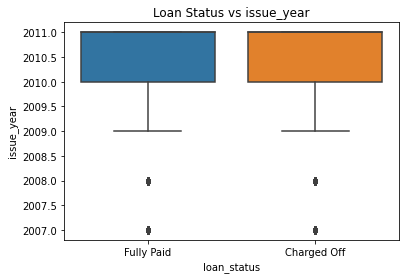

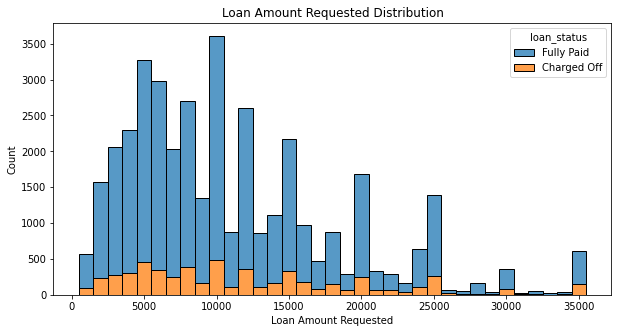

(10.165, 14.91]    17809
(5.401, 10.165]    12381
(14.91, 19.655]     7397
(19.655, 24.4]       990
Name: int_rate, dtype: int64


<Figure size 720x576 with 0 Axes>

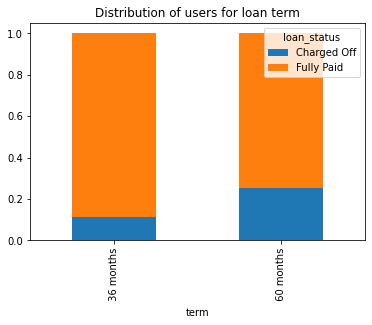

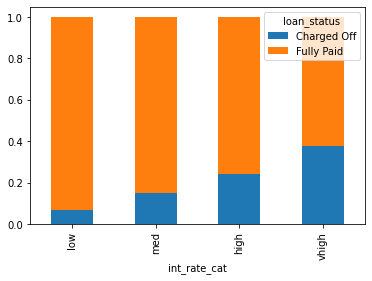

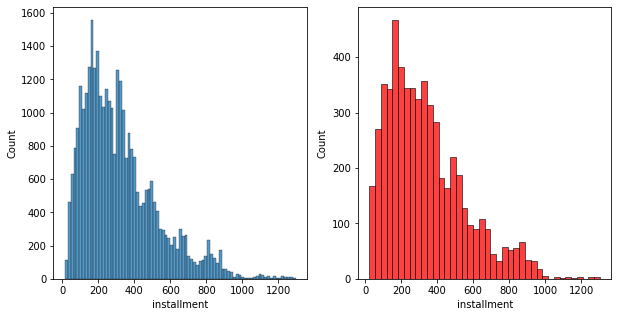

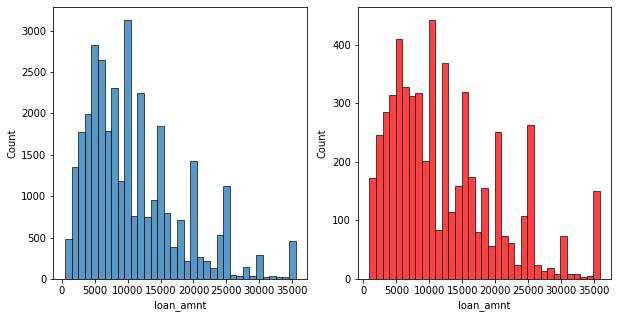

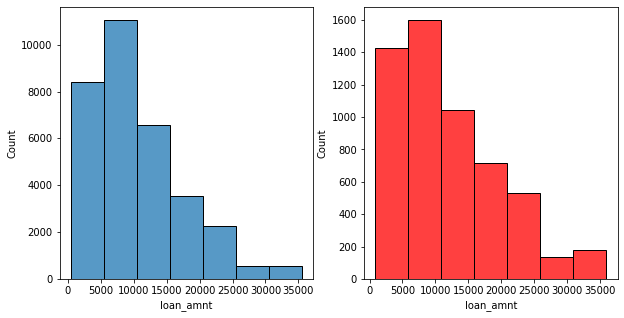

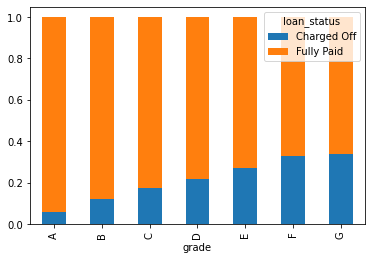

<Figure size 720x432 with 0 Axes>

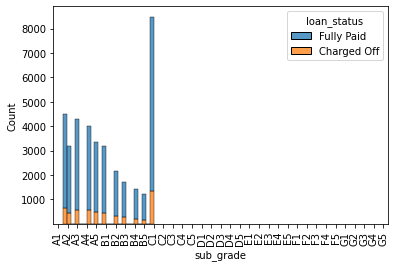

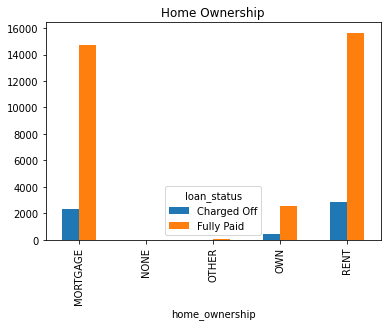

count      38577.00000
mean       68777.97368
std        64218.68180
min         4000.00000
25%        40000.00000
50%        58868.00000
75%        82000.00000
max      6000000.00000
Name: annual_inc, dtype: object


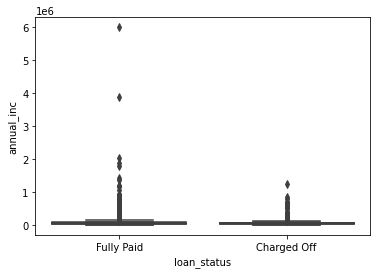

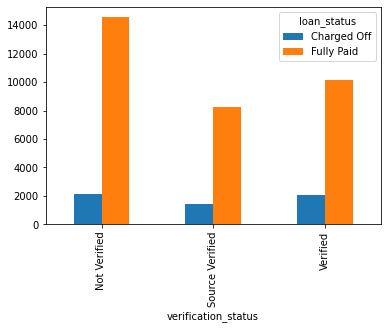

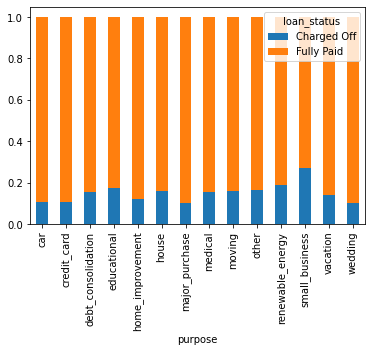

               count     mean     std    min     25%      50%      75%  \
loan_status                                                              
Charged Off  5627.00 12104.39 8085.73 900.00 5600.00 10000.00 16500.00   
Fully Paid  32950.00 10866.46 7199.63 500.00 5200.00  9600.00 15000.00   

                 max  
loan_status           
Charged Off 35000.00  
Fully Paid  35000.00  
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes

top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


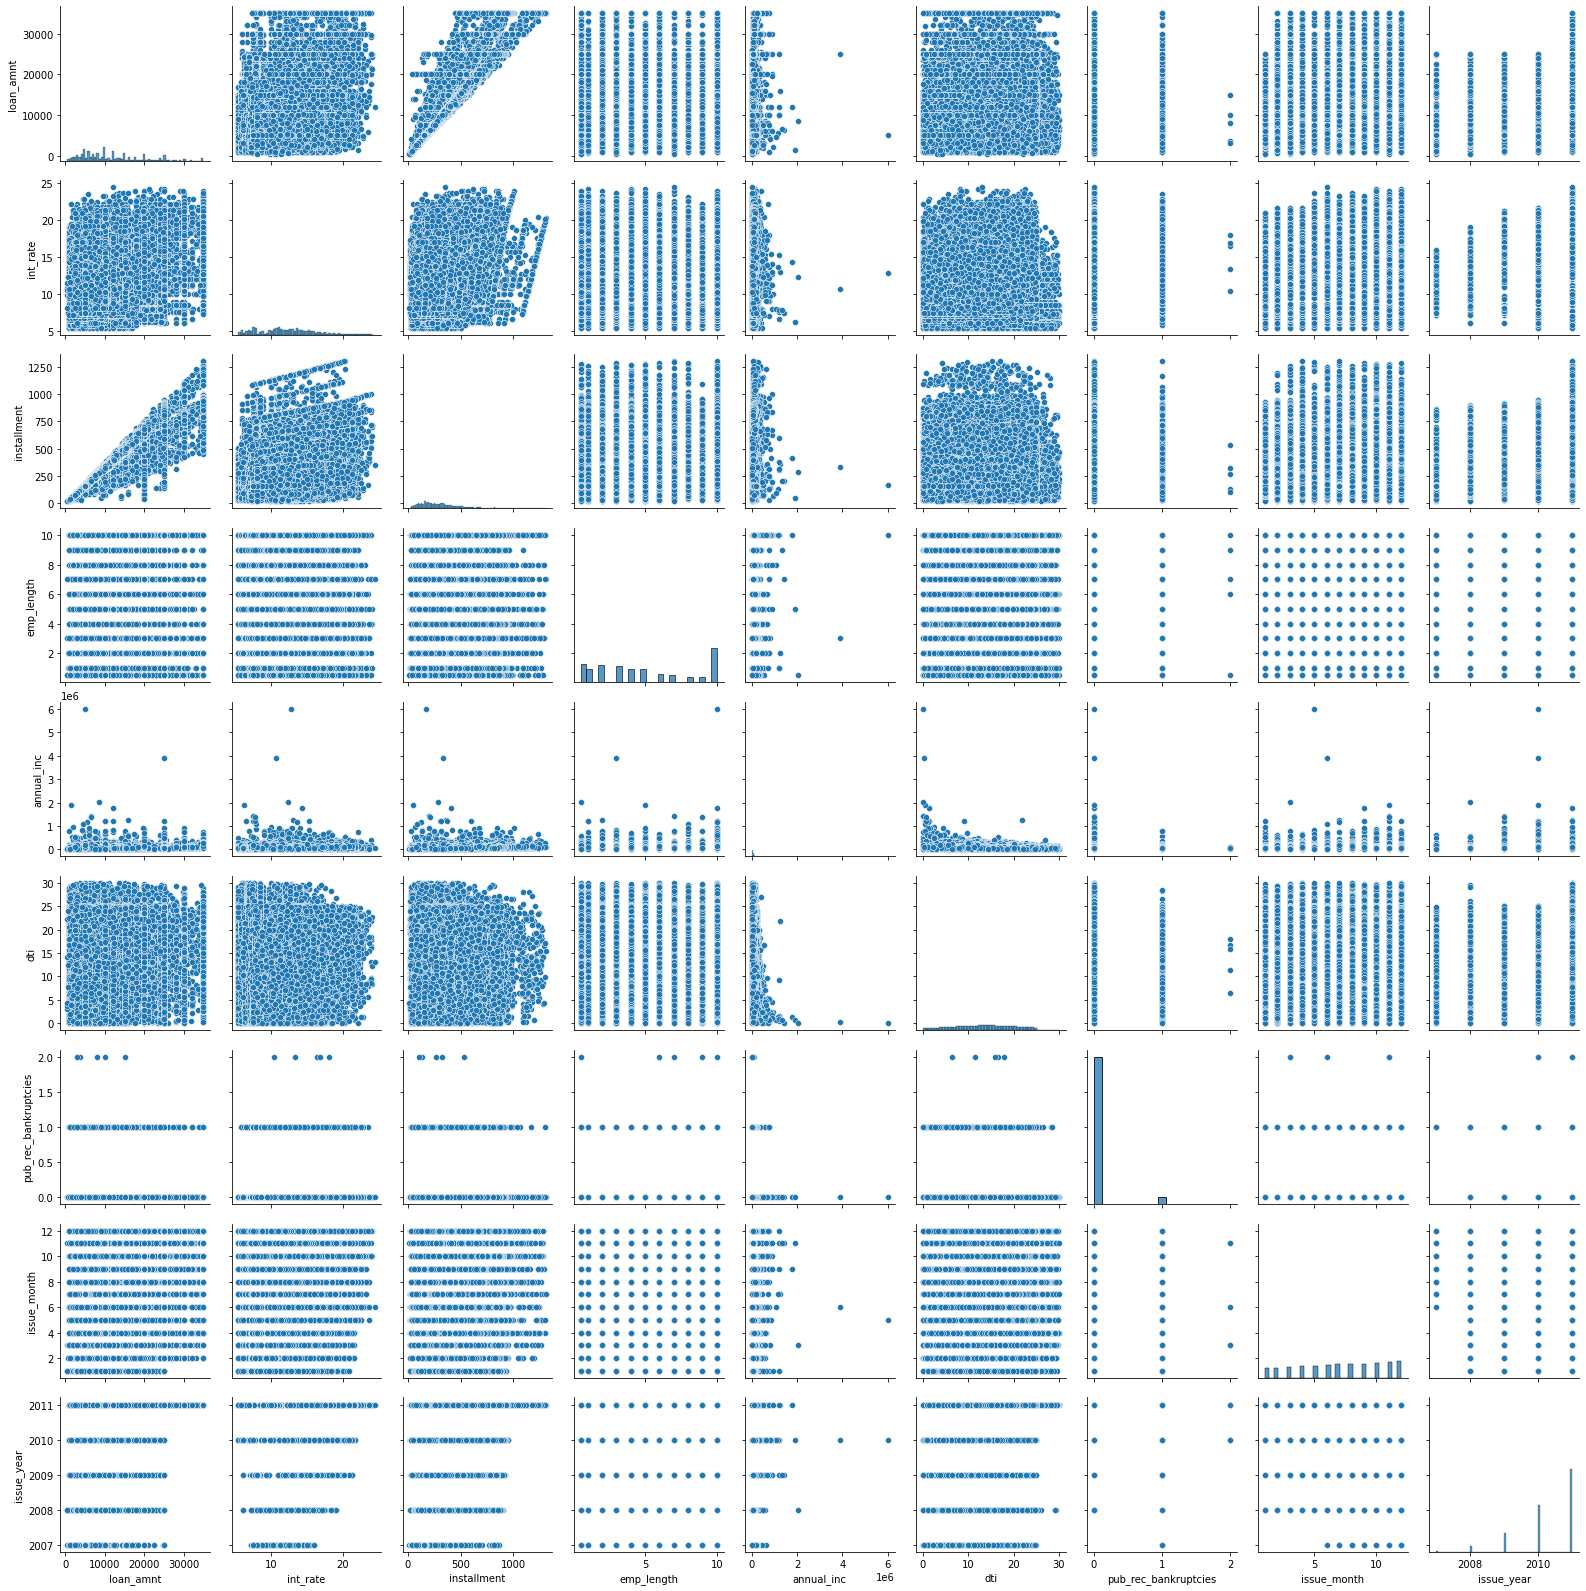

----------------------------------------------------------------------------------------------------
Loan Status vs. Verification Status Statistics
----------------------------------------------------------------------------------------------------
verification_status  Not Verified  Source Verified  Verified
loan_status                                                 
Charged Off                 38.07            25.48     36.45
Fully Paid                  44.16            25.02     30.82


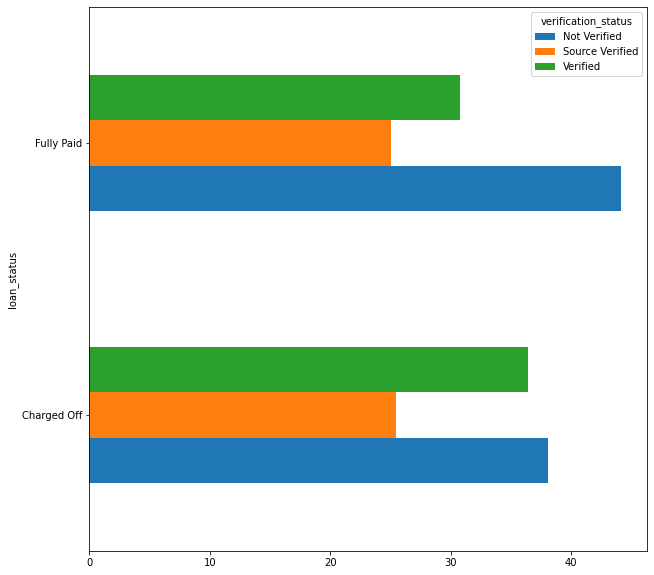

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x139a0d970>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x139a0d970> on colorbar
Setting pcolormesh


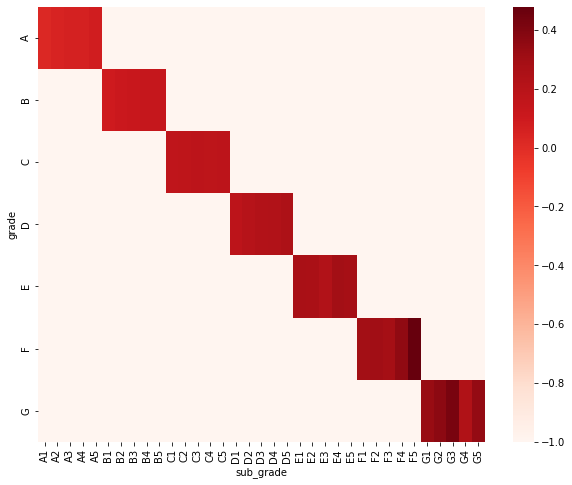

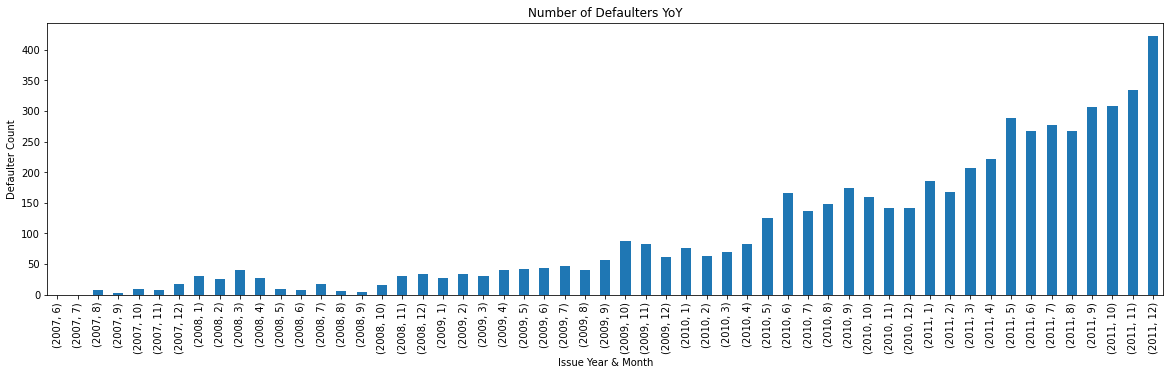

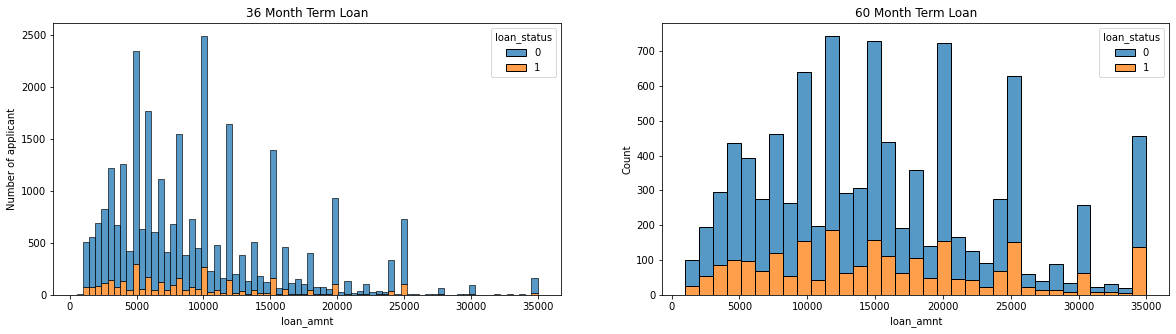

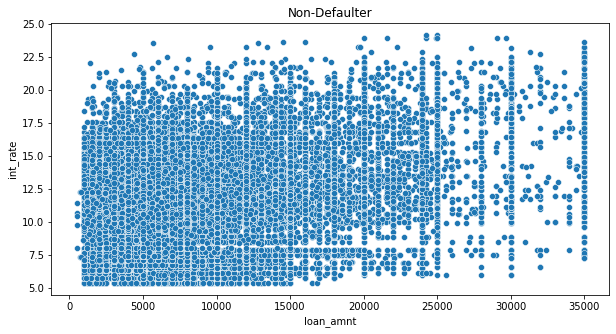

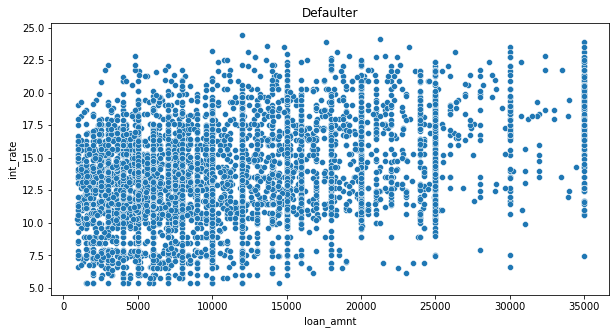

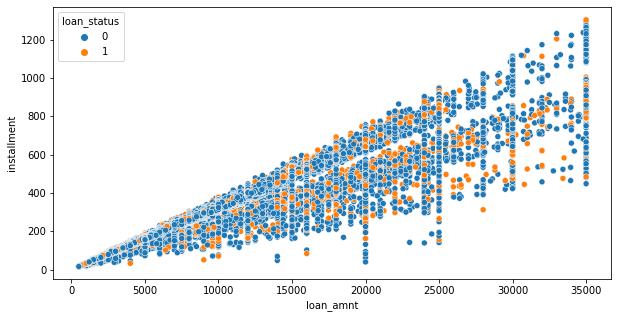

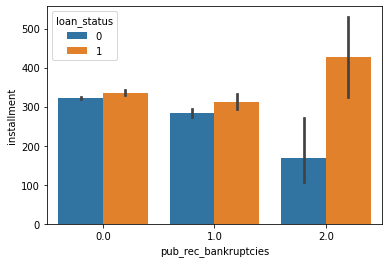

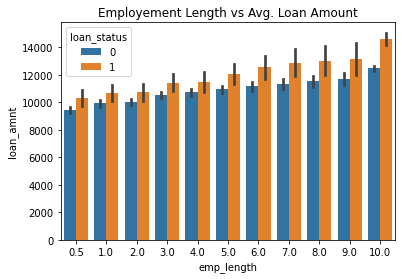

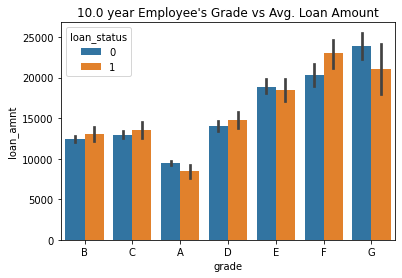

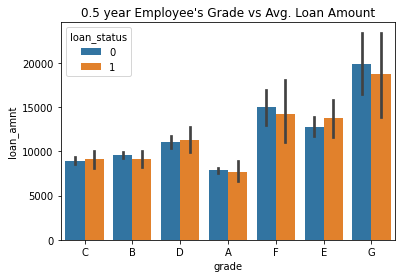

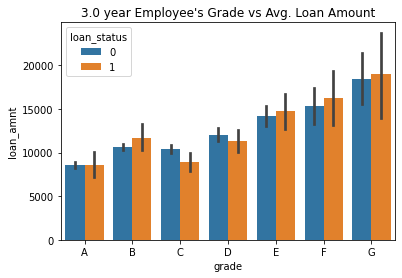

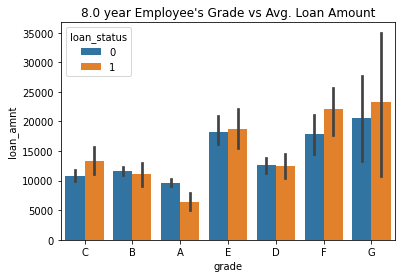

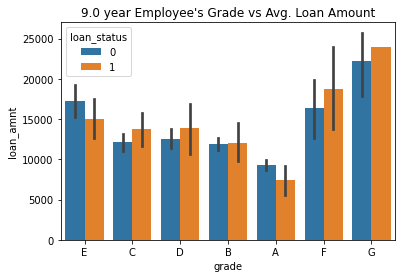

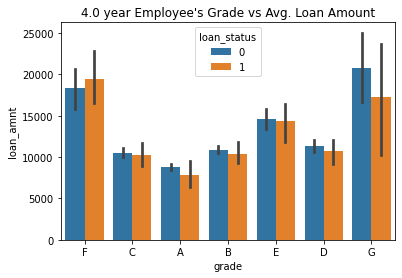

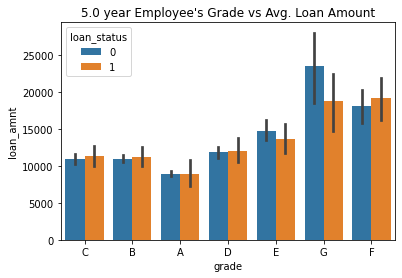

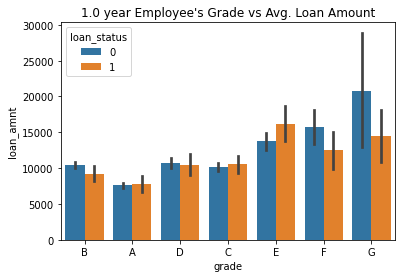

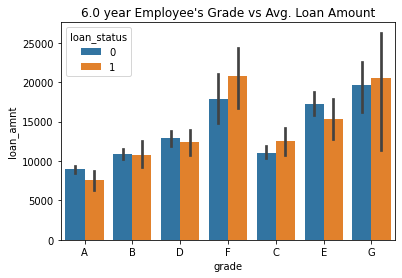

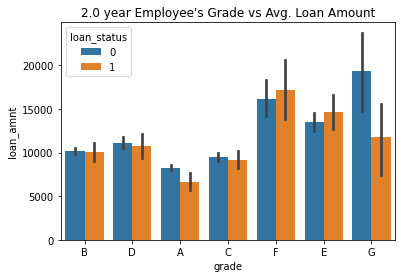

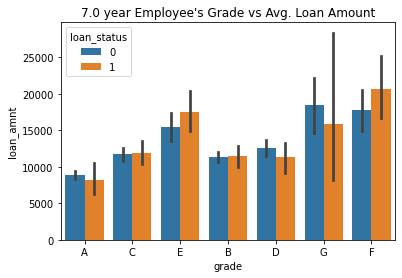

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1366d8940>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x1366d8940> on colorbar
Setting pcolormesh


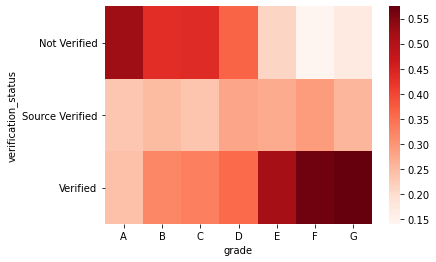

               count     mean      std     min      25%      50%      75%  \
loan_status                                                                 
0           32950.00 69862.50 66562.25 4000.00 41132.75 60000.00 84000.00   
1            5627.00 62427.30 47776.01 4080.00 37000.00 53000.00 75000.00   

                   max  
loan_status             
0           6000000.00  
1           1250000.00  
               count     mean      std     min      25%      50%      75%  \
loan_status                                                                 
0           32950.00 69862.50 66562.25 4000.00 41132.75 60000.00 84000.00   
1            5627.00 62427.30 47776.01 4080.00 37000.00 53000.00 75000.00   

                   max  
loan_status             
0           6000000.00  
1           1250000.00  


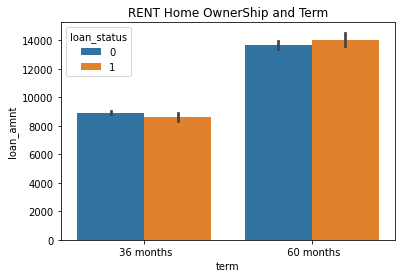

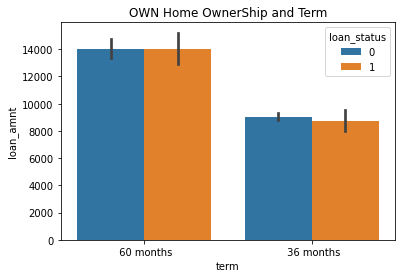

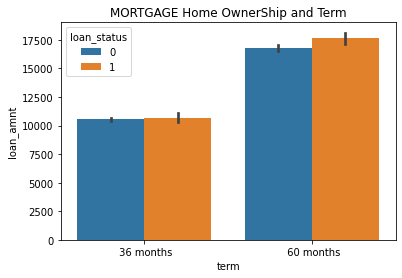

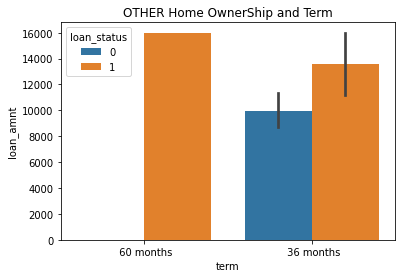

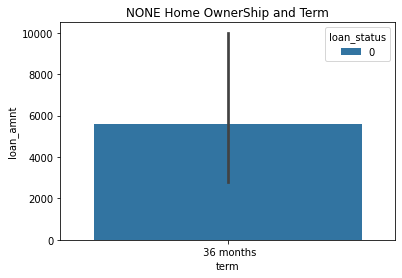

In [69]:
main()